# Preprocessing

https://dip.bundestag.de/%C3%BCber-dip/hilfe/api

https://search.dip.bundestag.de/api/v1/swagger-ui/#/


In [ ]:
!pip install xmltodict
!pip install tqdm

In [ ]:
# imports

import requests
import json
import os
import time
import shutil
import xmltodict
from datetime import datetime
from tqdm import tqdm
import pandas as pd
from pprint import pprint
import re
import spacy
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# config
QUERY_API_FLAG = True

API_KEY = "OSOegLs.PR2lwJ1dwCeje9vTj7FPOt3hvpYKtwKkhw"
API_BASE_URL = "https://search.dip.bundestag.de/api/v1/plenarprotokoll"
API_GRACE_PERIOD = 0.3

BASE_DIR = "data"
META_DIR = f"{BASE_DIR}/meta"
XML_DIR = f"{BASE_DIR}/xml"
REF_DOC_DIR = f"{BASE_DIR}/docs"

RESULTS_DIR = f"{BASE_DIR}/results"


In [ ]:
# !!! DO NOT EXECUTE !!!
# removes all data

#if QUERY_API_FLAG and os.path.exists(BASE_DIR):
#    shutil.rmtree(BASE_DIR)

In [ ]:
if QUERY_API_FLAG:

  # mount dirs
  os.makedirs(META_DIR, exist_ok=True)
  os.makedirs(XML_DIR, exist_ok=True)
  os.makedirs(REF_DOC_DIR, exist_ok=True)

  # set query params
  params = {
      "f.wahlperiode": 21,
      "format": "json",
      "apikey": API_KEY
  }

  r = requests.get(API_BASE_URL, params=params)
  r.raise_for_status()
  data = r.json()

  documents = data["documents"]
  ids = [doc["id"] for doc in documents]


  # load all protocol meta data as jsons
  for pid in tqdm(ids, desc="Downloading protocols", unit="doc"):
    try:
      protocol_url = f"{API_BASE_URL}/{pid}"

      # fetch protocol meta data
      r = requests.get(
          protocol_url,
          params={
              "format": "json",
              "apikey": API_KEY
          }
      )
      r.raise_for_status()
      protocol = r.json()

      # filter documents for:
      # - dokumentart (doc type),
      # - herausgeber (publisher),
      # - title wording "... des 21. Deutschen Bundestages"
      if protocol["dokumentart"].lower() != "plenarprotokoll" or protocol["herausgeber"] != "BT" or "21. Deutschen Bundestages" not in protocol["titel"]:
        continue

      # save results as json file
      out_path = f"{META_DIR}/{pid}.json"
      with open(out_path, "w", encoding="utf-8") as f:
          json.dump(protocol, f, ensure_ascii=False, indent=2)

      # get all references
      ref_docs = protocol.get("vorgangsbezug", [])

      if ref_docs:

          # iterate through all ref docs and fetch json
          for r in ref_docs:
              ref_id = r["id"]

              rv = requests.get(
                  f"https://search.dip.bundestag.de/api/v1/vorgang/{ref_id}",
                  params={"apikey": API_KEY}
              )
              rv.raise_for_status()

              with open(f"{REF_DOC_DIR}/{ref_id}.json", "w", encoding="utf-8") as vf:
                  json.dump(rv.json(), vf, ensure_ascii=False, indent=2)

              time.sleep(API_GRACE_PERIOD) # grace delay

      # check if has url for xml
      if "xml_url" not in protocol["fundstelle"]:
        tqdm.write(f"[API][ERROR] no xml url for {protocol["id"]} found; skip")
        continue


      xml_url = protocol["fundstelle"]["xml_url"]

      response = requests.get(xml_url, timeout=10)
      response.raise_for_status()

      # save as xml file
      with open(f"{XML_DIR}/{pid}.xml" , "wb") as xml_file:
          xml_file.write(response.content)

      time.sleep(API_GRACE_PERIOD) # grace period

    except Exception as e:
      tqdm.write(f"\n[API][ERROR] {e}\n")


[API][ERROR] no xml url for 5762 found; skip


[API][ERROR] no xml url for 5764 found; skip


[API][ERROR] no xml url for 5763 found; skip


[API][ERROR] no xml url for 5758 found; skip


[API][ERROR] no xml url for 5734 found; skip


# Analysis
The analysis can be done using 3 types of files. The metadata json holds the connecting data (referenced processes (vorgangsbezüge), the refence to the xml and date/time, publisher, etc. infos  (meta data).

First the files need to be indexed (to get the ids); then the analysis can be done...




In [ ]:
# get protocol ids from dir (indexing basically)

protocol_ids = [
    f.split('.')[0]
    for f in os.listdir(META_DIR)
    if f.endswith('.json')
]

protocol_ids.sort()

In [ ]:
def load_xml_root(xml_path):
    with open(xml_path, "rb") as f:
        data = xmltodict.parse(f.read())
    return data.get('dbtplenarprotokoll', {})

def force_list(obj):
    if not obj: return []
    return obj if isinstance(obj, list) else [obj]

In [ ]:
def get_duration_info(root):
    start_str = root.get("@sitzung-start-uhrzeit")
    end_str = root.get("@sitzung-ende-uhrzeit")

    fmt = "%H:%M"
    start_dt = datetime.strptime(start_str, fmt)
    end_dt = datetime.strptime(end_str, fmt)

    duration_minutes = (end_dt - start_dt).seconds // 60
    return {
        "begin": start_str,
        "end": end_str,
        "duration_min": duration_minutes,
        "duration_h": round(duration_minutes / 60, 2)
    }

In [ ]:
def get_speaker_counts(root):
    speaker_list = force_list(root.get('rednerliste', {}).get('redner', []))

    parties = {}
    for speaker in speaker_list:
        p = speaker.get('name', {}).get('fraktion', 'Sonstige')
        parties[p] = parties.get(p, 0) + 1

    return {
        "total_active_speakers": len(speaker_list),
        "by_party": parties
    }

In [ ]:
def get_content_density(root):
    history_ref = root.get('sitzungsverlauf', {})
    agenda_points = force_list(history_ref.get('tagesordnungspunkt', []))

    count_speeches = 0
    for agenda in agenda_points:
        count_speeches += len(force_list(agenda.get('rede', [])))

    return {
        "total_agenda": len(agenda_points),
        "total_speeches": count_speeches,
        "speeches_per_agenda": round(count_speeches / len(agenda_points), 1) if agenda_points else 0
    }

In [ ]:
def extract_interjections(root):

    interjections = []

    # navigate to the speeches
    verlauf = root.get('sitzungsverlauf', {})
    tops = force_list(verlauf.get('tagesordnungspunkt', []))

    for top in tops:
        speeches = force_list(top.get('rede', []))
        for speech in speeches:

            comments = force_list(speech.get('kommentar', []))
            for c in comments:

                # handle cases where c is a dict or a plain string
                text = c if isinstance(c, str) else c.get('#text', '')
                if text:
                    interjections.append(text)
    return interjections

In [ ]:
def calculate_interjection_stats(interjections_list):

    parties = ["SPD", "CDU/CSU", "BÜNDNIS 90/DIE GRÜNEN", "FDP", "AfD", "DIE LINKE", "BSW", "Fraktionslos"]
    stats = {
        "by_party": {p: 0 for p in parties},
        "by_type": {
            "Beifall": 0,
            "Lachen": 0,
            "Heiterkeit": 0,
            "Widerspruch": 0,
            "Zuruf": 0
        },
        "total": len(interjections_list)
    }

    for text in interjections_list:
        # check Party (often written as 'Beifall bei der SPD' or 'Zuruf der AfD')
        for party in parties:
            if party in text:
                stats["by_party"][party] += 1

        # check Type (Standard phrases in German protocols)
        if "Beifall" in text: stats["by_type"]["Beifall"] += 1
        if "Lachen" in text: stats["by_type"]["Lachen"] += 1
        if "Heiterkeit" in text: stats["by_type"]["Heiterkeit"] += 1
        if "Widerspruch" in text: stats["by_type"]["Widerspruch"] += 1
        if "Zuruf" in text: stats["by_type"]["Zuruf"] += 1

    return stats

In [ ]:
def analyze_xml_protocol(xml_path):

  root = load_xml_root(f"{XML_DIR}/{id}.xml")

  # calc intersecitons (Zwischenrufe)
  raw_interjections = extract_interjections(root)
  interjection_analysis = calculate_interjection_stats(raw_interjections)

  # save results
  results = {
      "id": root.get("@sitzung-nr"),
      "date": root.get("@sitzung-datum"),
      "interjection_stats": interjection_analysis,
      "time": get_duration_info(root),
      "activity": get_speaker_counts(root),
      "structure": get_content_density(root),
  }

  return results

## Reference docs (Vorgangsbezüge)

In [ ]:
# analysis related process docs (vorgangsbezüge)

def analyze_ref_docs(protocol_meta_dict):

    ref_docs = []
    stats = {
        "top_subjects": {},
        "initiator_distribution": {},
        "type_breakdown": {}
    }

    ref_list = protocol_meta_dict.get("vorgangsbezug", [])

    for v_ref in ref_list:
        v_id = v_ref.get("id")
        v_file = os.path.join(REF_DOC_DIR, f"{v_id}.json")

        if os.path.exists(v_file):
            with open(v_file, "r", encoding="utf-8") as vf:
                v_data = json.load(vf)

                # extract data
                doc_type = v_data.get("vorgangstyp", "Unknown")
                subjects = v_data.get("sachgebiet", [])
                initiators = v_data.get("initiative", [])

                ref_docs.append({
                    "doc_id": v_id,
                    "title": v_data.get("titel"),
                    "type": doc_type,
                    "subjects": subjects,
                    "initiators": initiators
                })

                # count type
                stats["type_breakdown"][doc_type] = stats["type_breakdown"].get(doc_type, 0) + 1

                # count sbjects
                for s in subjects:
                    stats["top_subjects"][s] = stats["top_subjects"].get(s, 0) + 1

                # count initiators
                for i in initiators:
                    stats["initiator_distribution"][i] = stats["initiator_distribution"].get(i, 0) + 1


                # tbc...

    return {
        "stats": stats,
        "total": len(ref_docs)
    }

## Meta JSON file analysis

In [ ]:
def analyze_protocol_meta(protocol_meta_dict):

    # tbc ...
    analysis = {
        "date": protocol_meta_dict.get("datum"),
        "last_updated": protocol_meta_dict.get("aktualisiert"),
        "page_count": protocol_meta_dict.get("seiten"),
        "title_length": len(protocol_meta_dict.get("titel", "")),
    }


    return analysis

## Running analysis

In [ ]:
RUN_REFERENCE_ANALYSIS_FLAG = True
RUN_XML_PROTOCOL_ANALYSIS_FLAG = True
RUN_META_ANALYSIS_FLAG = True

In [ ]:
ref_analysis_results = {}
xml_analysis_results = {}
meta_analysis_results = {}

for id in tqdm(protocol_ids, desc="Processing Protocols", unit="file"):
  try:
    # load meta data json (index file)
    with open(f"{META_DIR}/{id}.json", "r", encoding="utf-8") as f:
        protocol_meta_dict = json.load(f)

    if RUN_META_ANALYSIS_FLAG:
      meta_analysis_results[id] = analyze_protocol_meta(protocol_meta_dict)


    # analysis of related process docs (vorgangsbezüge)
    if RUN_REFERENCE_ANALYSIS_FLAG:
      ref_analysis_results[id] = analyze_ref_docs(protocol_meta_dict)

    # analysis of xml protocol file
    if RUN_XML_PROTOCOL_ANALYSIS_FLAG:
      xml_analysis_results[id] = analyze_xml_protocol(f"{XML_DIR}/{id}.xml")

  except Exception as e:
    tqdm.write(f"\n[ERROR] {id}: {e}")

# tbc...

Processing Protocols:  65%|██████▍   | 33/51 [00:01<00:00, 27.61file/s]


[ERROR] 5734: [Errno 2] No such file or directory: 'data/xml/5734.xml'


Processing Protocols: 100%|██████████| 51/51 [00:01<00:00, 25.72file/s]


[ERROR] 5758: [Errno 2] No such file or directory: 'data/xml/5758.xml'


In [ ]:
# work with meta json analysis results ...

# iterating over each session (sitzung)
for session_id, analysis in meta_analysis_results.items():
    print(f"--- Analysis for Session {session_id} Meta data---")

    print(json.dumps(analysis, indent=2, ensure_ascii=False))
    print("\n" + "="*40 + "\n")

--- Analysis for Session 5702 Meta data---
{
  "date": "2025-03-25",
  "last_updated": "2025-03-26T09:52:31+01:00",
  "page_count": null,
  "title_length": 54
}


--- Analysis for Session 5705 Meta data---
{
  "date": "2025-05-06",
  "last_updated": "2025-05-07T09:54:40+02:00",
  "page_count": null,
  "title_length": 54
}


--- Analysis for Session 5706 Meta data---
{
  "date": "2025-05-14",
  "last_updated": "2025-05-20T11:19:30+02:00",
  "page_count": null,
  "title_length": 54
}


--- Analysis for Session 5707 Meta data---
{
  "date": "2025-05-15",
  "last_updated": "2025-06-03T11:50:39+02:00",
  "page_count": null,
  "title_length": 54
}


--- Analysis for Session 5708 Meta data---
{
  "date": "2025-05-16",
  "last_updated": "2025-05-26T17:06:31+02:00",
  "page_count": null,
  "title_length": 54
}


--- Analysis for Session 5709 Meta data---
{
  "date": "2025-05-21",
  "last_updated": "2025-06-06T11:05:21+02:00",
  "page_count": null,
  "title_length": 54
}


--- Analysis for Sessi

In [ ]:
# work with reference docs analysis results ...

# iterating over each session (Sitzung)
for session_id, analysis in ref_analysis_results.items():
    print(f"--- Analysis for Session {session_id} ---")

    print(json.dumps(analysis, indent=2, ensure_ascii=False))
    print("\n" + "="*40 + "\n")

--- Analysis for Session 5702 ---
{
  "stats": {
    "top_subjects": {
      "Bundestag": 4
    },
    "initiator_distribution": {
      "Fraktion der CDU/CSU": 2,
      "Fraktion der SPD": 2,
      "Fraktion der AfD": 2
    },
    "type_breakdown": {
      "Geschäftsordnung": 3,
      "Antrag": 1
    }
  },
  "total": 4
}


--- Analysis for Session 5705 ---
{
  "stats": {
    "top_subjects": {},
    "initiator_distribution": {},
    "type_breakdown": {
      "Wahl im BT": 1,
      "Ansprache/Erklärung/Mitteilung": 3
    }
  },
  "total": 4
}


--- Analysis for Session 5706 ---
{
  "stats": {
    "top_subjects": {},
    "initiator_distribution": {},
    "type_breakdown": {
      "Mündliche Frage": 4
    }
  },
  "total": 4
}


--- Analysis for Session 5707 ---
{
  "stats": {
    "top_subjects": {
      "Bundestag": 1
    },
    "initiator_distribution": {
      "Fraktion der CDU/CSU": 1,
      "Fraktion der SPD": 1
    },
    "type_breakdown": {
      "Regierungserklärung": 1,
      "A

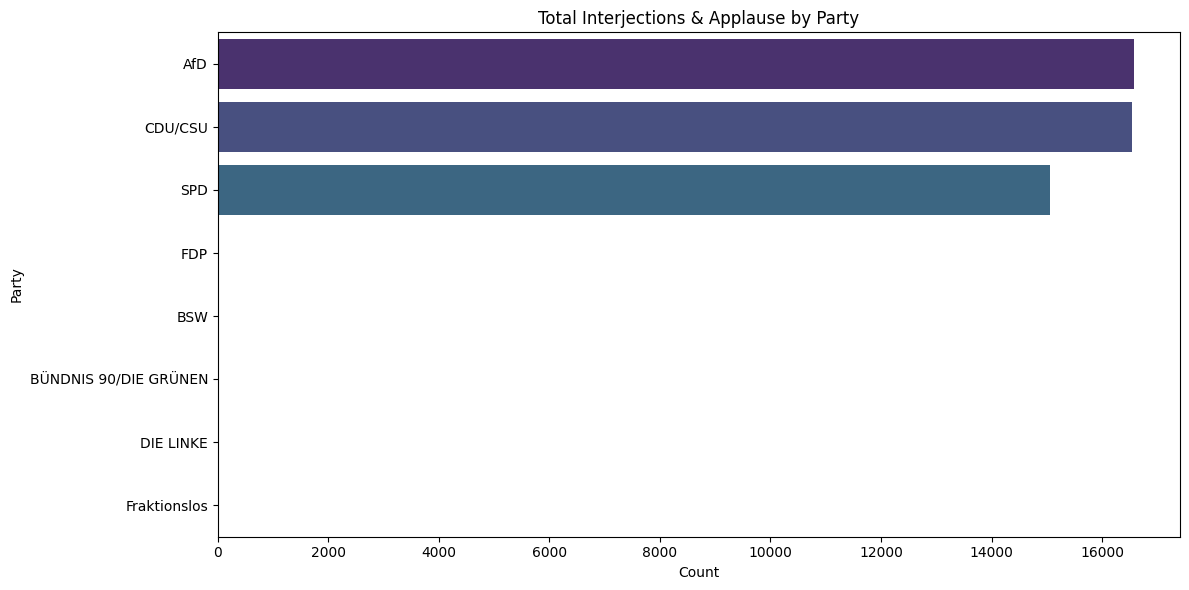

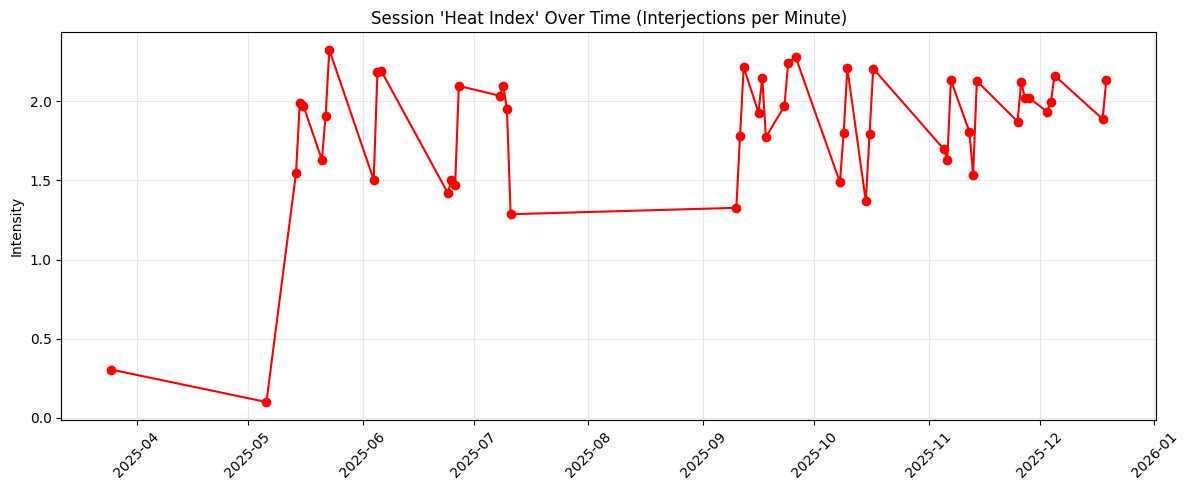

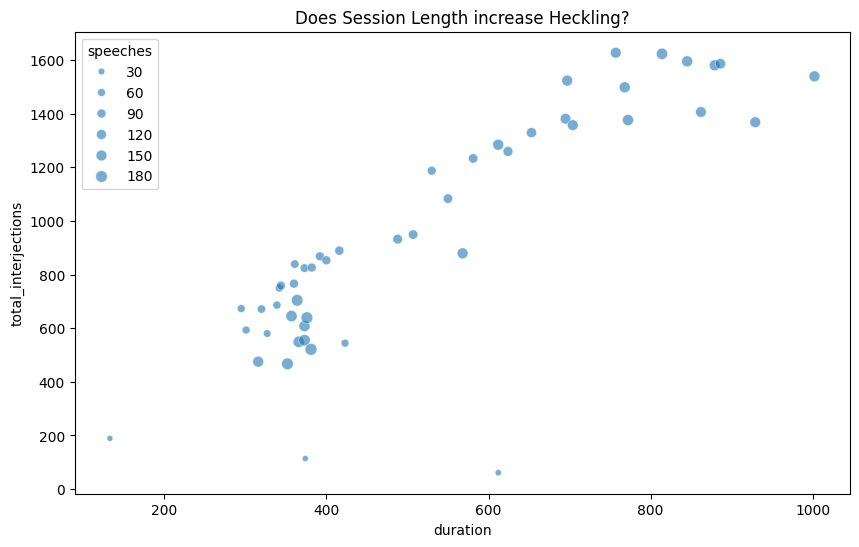

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --- FIX 1: Ensure Directory Exists ---
os.makedirs(RESULTS_DIR, exist_ok=True)

# 1. Data Preparation
data_list = []
for sid, analysis in xml_analysis_results.items():
    row = {
        "session_id": sid,
        "date": analysis["date"],
        "duration": analysis["time"]["duration_min"],
        "total_interjections": analysis["interjection_stats"]["total"],
        "speeches": analysis["structure"]["total_speeches"]
    }
    for party, count in analysis["interjection_stats"]["by_party"].items():
        row[f"party_{party}"] = count
    for itype, count in analysis["interjection_stats"]["by_type"].items():
        row[f"type_{itype}"] = count
    data_list.append(row)

df = pd.DataFrame(data_list)

# --- FIX 2: Explicit Date Format to silence warning ---
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.sort_values('date')

# --- Analysis 1: Party Activity ---
plt.figure(figsize=(12, 6))
party_cols = [c for c in df.columns if c.startswith('party_')]
party_totals = df[party_cols].sum().sort_values(ascending=False)
clean_names = [n.replace('party_', '') for n in party_totals.index]

# --- FIX 3: Updated Seaborn syntax (hue assigned to y) ---
sns.barplot(
    x=party_totals.values,
    y=clean_names,
    hue=clean_names,
    palette="viridis",
    legend=False
)

plt.title("Total Interjections & Applause by Party")
plt.xlabel("Count")
plt.ylabel("Party")
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/plot_party_activity.png")
plt.show()

# --- Analysis 2: Heat Timeline ---
plt.figure(figsize=(12, 5))
# Moving average for smoother trend
df['heat_index'] = df['total_interjections'] / df['duration']
plt.plot(df['date'], df['heat_index'], marker='o', linestyle='-', color='red')
plt.title("Session 'Heat Index' Over Time (Interjections per Minute)")
plt.ylabel("Intensity")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/plot_heat_timeline.png")
plt.show()

# --- Analysis 3: Interaction vs. Duration ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="duration", y="total_interjections", size="speeches", alpha=0.6)
plt.title("Does Session Length increase Heckling?")
plt.savefig(f"{RESULTS_DIR}/plot_correlation.png")
plt.show()

In [ ]:
# work with xml protocol analysis results ...
for session_id, analysis in xml_analysis_results.items():
    print(f"--- Analysis for XML Protocols {session_id} ---")

    print(json.dumps(analysis, indent=2, ensure_ascii=False))
    print("\n" + "="*40 + "\n")

--- Analysis for XML Protocols 5702 ---
{
  "id": "1",
  "date": "25.03.2025",
  "interjection_stats": {
    "by_party": {
      "SPD": 43,
      "CDU/CSU": 29,
      "BÜNDNIS 90/DIE GRÜNEN": 0,
      "FDP": 0,
      "AfD": 56,
      "DIE LINKE": 0,
      "BSW": 0,
      "Fraktionslos": 0
    },
    "by_type": {
      "Beifall": 76,
      "Lachen": 5,
      "Heiterkeit": 1,
      "Widerspruch": 2,
      "Zuruf": 16
    },
    "total": 114
  },
  "time": {
    "begin": "11:00",
    "end": "17:14",
    "duration_min": 374,
    "duration_h": 6.23
  },
  "activity": {
    "total_active_speakers": 15,
    "by_party": {
      "AfD": 2,
      "CDU/CSU": 5,
      "SPD": 3,
      "BÜNDNIS 90/DIE GRÜNEN": 2,
      "Die Linke": 2,
      "fraktionslos": 1
    }
  },
  "structure": {
    "total_agenda": 8,
    "total_speeches": 17,
    "speeches_per_agenda": 2.1
  }
}


--- Analysis for XML Protocols 5705 ---
{
  "id": "2",
  "date": "06.05.2025",
  "interjection_stats": {
    "by_party": {
      "

# Data Discovery

Data structure

We work with three connected file types per plenary session:

	1.	Meta JSON (Protocol metadata)
This file is the “index card” of a plenary protocol. It contains the session date and title, and—most importantly—links to the official protocol files (e.g., xml_url and pdf_url). It also lists referenced parliamentary processes (Vorgangsbezüge), which connect the session to additional contextual documents.

	2.	XML protocol (Plenary content)
This file contains the full structured record of the session: the agenda flow (Sitzungsverlauf with Tagesordnungspunkte), the speeches (Reden), and the speaker list (Rednerliste). It includes session attributes like start/end time, and it is the main source for extracting speech texts, speakers, party/faction labels, and interaction markers (e.g., applause/interjections).

	3.	Reference docs (Vorgang JSON)
These are additional context files linked via Vorgangsbezug. They describe the underlying parliamentary process, including type (Vorgangstyp), subjects (Sachgebiet), and initiators (Initiative). They help interpret and categorize what is being debated, beyond the raw speech text.

In [ ]:
# data integrity check
BASE_DIR = 'data'
META_DIR = f'{BASE_DIR}/meta'
XML_DIR = f'{BASE_DIR}/xml'
REF_DOC_DIR = f'{BASE_DIR}/docs'
RESULTS_DIR = f'{BASE_DIR}/results'

def count_files(folder):
    if not os.path.exists(folder):
        return 0, {}
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    ext_counts = {}
    for f in files:
        ext = f.split('.')[-1].lower() if '.' in f else ''
        ext_counts[ext] = ext_counts.get(ext, 0) + 1
    return len(files), ext_counts

print('--- Folder inventory ---')
for name, folder in [
    ('META_DIR', META_DIR),
    ('XML_DIR', XML_DIR),
    ('REF_DOC_DIR', REF_DOC_DIR),
    ('RESULTS_DIR', RESULTS_DIR)
]:
    n, exts = count_files(folder)
    print(name, '->', n, 'files')
    print('  by extension:', exts)

print('\n--- Protocol alignment (meta vs xml) ---')
meta_ids = {f.split('.')[0] for f in os.listdir(META_DIR) if f.endswith('.json')}
xml_ids  = {f.split('.')[0] for f in os.listdir(XML_DIR) if f.endswith('.xml')}

aligned = meta_ids & xml_ids
only_meta = meta_ids - xml_ids
only_xml = xml_ids - meta_ids

print('Meta protocols:', len(meta_ids))
print('XML protocols:', len(xml_ids))
print('Aligned (meta + xml):', len(aligned))
print('Meta only (missing xml):', len(only_meta))
print('XML only (missing meta):', len(only_xml))

print('\nExamples missing xml:', sorted(list(only_meta))[:10])
print('Examples missing meta:', sorted(list(only_xml))[:10])

--- Folder inventory ---
META_DIR -> 54 files
  by extension: {'json': 54}
XML_DIR -> 49 files
  by extension: {'xml': 49}
REF_DOC_DIR -> 141 files
  by extension: {'json': 141}
RESULTS_DIR -> 0 files
  by extension: {}

--- Protocol alignment (meta vs xml) ---
Meta protocols: 54
XML protocols: 49
Aligned (meta + xml): 49
Meta only (missing xml): 5
XML only (missing meta): 0

Examples missing xml: ['5734', '5758', '5762', '5763', '5764']
Examples missing meta: []


In [ ]:
# Master list
aligned_ids = sorted(list(meta_ids & xml_ids))

rows = []
for pid in aligned_ids:
    with open(f'{META_DIR}/{pid}.json', 'r', encoding='utf-8') as f:
        meta = json.load(f)
    rows.append({'protocol_id': pid, 'date': meta.get('datum')})

dates_df = pd.DataFrame(rows)
dates_df['date'] = pd.to_datetime(dates_df['date'], errors='coerce')

print('Number of protocols (aligned):', dates_df.shape[0])
print('Min date:', dates_df['date'].min().date())
print('Max date:', dates_df['date'].max().date())

dates_df.sort_values('date').head()

Number of protocols (aligned): 49
Min date: 2025-03-25
Max date: 2025-12-19


,protocol_id,date
0,5702,2025-03-25
1,5705,2025-05-06
2,5706,2025-05-14
3,5707,2025-05-15
4,5708,2025-05-16


In [ ]:
# Inspection of one TOP and one speech (rede)
XML_DIR = 'data/xml'

def force_list(x):
    if not x:
        return []
    return x if isinstance(x, list) else [x]

def load_xml_root(protocol_id):
    path = os.path.join(XML_DIR, f'{protocol_id}.xml')
    with open(path, 'rb') as f:
        data = xmltodict.parse(f.read())
    return data.get('dbtplenarprotokoll', {}) or {}

def shallow_preview(obj, max_items=8):
    """
    Show a shallow preview of dict/list without printing full nested content.
    """
    if isinstance(obj, dict):
        out = {}
        for k in list(obj.keys())[:max_items]:
            v = obj[k]
            if isinstance(v, (dict, list)):
                out[k] = f'<{type(v).__name__} with {len(v) if isinstance(v, list) else len(v.keys())} items>'
            else:
                out[k] = v
        return out
    if isinstance(obj, list):
        return f'<list with {len(obj)} items>'
    return obj

# Pick one protocol id
pid = aligned_ids[0]
root = load_xml_root(pid)

print('Protocol:', pid)
print('Top-level keys:')
print(list(root.keys()))

# --- Inspect agenda points (TOPs) ---
verlauf = root.get('sitzungsverlauf', {}) or {}
tops = force_list(verlauf.get('tagesordnungspunkt', []))

print('\nNumber of TOPs:', len(tops))

top0 = tops[0] if len(tops) > 0 else {}
print('\n--- TOP[0] keys ---')
print(list(top0.keys()))

print('\n--- TOP[0] shallow preview ---')
pprint(shallow_preview(top0))

# Try common title candidates
print('\n--- TOP[0] possible title fields ---')
candidates = ['titel', '@titel', 'top', '@top', 'nr', '@nr', '@top-id', 'bezeichnung', 'ueberschrift']
for c in candidates:
    if c in top0:
        print(c, '->', shallow_preview(top0.get(c)))

# --- Inspect first speech inside TOP[0] ---
speeches0 = force_list(top0.get('rede', []))
print('\nSpeeches in TOP[0]:', len(speeches0))

rede0 = speeches0[0] if len(speeches0) > 0 else {}
print('\n--- rede[0] keys ---')
print(list(rede0.keys()))

print('\n--- rede[0] shallow preview ---')
pprint(shallow_preview(rede0))

# Speaker block inside speech (often 'redner')
redner0 = rede0.get('redner', {}) or {}
print('\n--- rede[0][redner] keys ---')
print(list(redner0.keys()) if isinstance(redner0, dict) else type(redner0))

print('\n--- rede[0] possible speaker id fields ---')
id_candidates = ['@redner-id', '@rednerid', '@id']
for c in id_candidates:
    if c in rede0:
        print('rede0', c, '->', rede0.get(c))
for c in id_candidates:
    if isinstance(redner0, dict) and c in redner0:
        print('redner0', c, '->', redner0.get(c))

# --- Inspect speaker list (rednerliste) ---
rednerliste = root.get('rednerliste', {}) or {}
speaker_list = force_list(rednerliste.get('redner', []))

print('\nNumber of speakers in rednerliste:', len(speaker_list))
sp0 = speaker_list[0] if len(speaker_list) > 0 else {}
print('\n--- rednerliste[0] keys ---')
print(list(sp0.keys()))

print('\n--- rednerliste[0] shallow preview ---')
pprint(shallow_preview(sp0))

name0 = (sp0.get('name') or {}) if isinstance(sp0, dict) else {}
print('\n--- rednerliste[0][name] keys ---')
print(list(name0.keys()) if isinstance(name0, dict) else type(name0))

Protocol: 5702
Top-level keys:
['@vertrieb', '@herstellung', '@sitzung-ort', '@herausgeber', '@issn', '@wahlperiode', '@sitzung-nr', '@sitzung-datum', '@sitzung-start-uhrzeit', '@sitzung-ende-uhrzeit', '@sitzung-naechste-datum', '@start-seitennr', 'vorspann', 'sitzungsverlauf', 'anlagen', 'rednerliste']

Number of TOPs: 8

--- TOP[0] keys ---
['@top-id', 'p', 'kommentar', 'rede', 'name']

--- TOP[0] shallow preview ---
{'@top-id': 'Zur Geschäftsordnung',
 'kommentar': '<list with 2 items>',
 'name': 'Alterspräsident Dr.\xa0Gregor Gysi:',
 'p': '<list with 3 items>',
 'rede': '<list with 5 items>'}

--- TOP[0] possible title fields ---
@top-id -> Zur Geschäftsordnung

Speeches in TOP[0]: 5

--- rede[0] keys ---
['@id', 'p', 'kommentar', 'name']

--- rede[0] shallow preview ---
{'@id': 'ID21100100',
 'kommentar': '<list with 15 items>',
 'name': '<list with 6 items>',
 'p': '<list with 28 items>'}

--- rede[0][redner] keys ---
[]

--- rede[0] possible speaker id fields ---
rede0 @id -> I

In [ ]:
# Inspection: rede['name'] for a few speeches
pid = aligned_ids[0]
root = load_xml_root(pid)

verlauf = root.get('sitzungsverlauf', {}) or {}
tops = force_list(verlauf.get('tagesordnungspunkt', []))

top0 = tops[0]
speeches0 = force_list(top0.get('rede', []))

print('Protocol:', pid)
print('TOP:', top0.get('@top-id'))
print('Speeches in TOP:', len(speeches0))

for i in range(min(3, len(speeches0))):
    rede = speeches0[i]
    print('\n--- Speech', i, '---')
    print('rede_id:', rede.get('@id'))
    print('name field type:', type(rede.get('name')))
    pprint(rede.get('name'))

Protocol: 5702
TOP: Zur Geschäftsordnung
Speeches in TOP: 5

--- Speech 0 ---
rede_id: ID21100100
name field type: <class 'list'>
['Alterspräsident Dr.\xa0Gregor Gysi:',
 'Alterspräsident Dr.\xa0Gregor Gysi:',
 'Alterspräsident Dr.\xa0Gregor Gysi:',
 'Alterspräsident Dr.\xa0Gregor Gysi:',
 'Alterspräsident Dr.\xa0Gregor Gysi:',
 'Alterspräsident Dr.\xa0Gregor Gysi:']

--- Speech 1 ---
rede_id: ID21100200
name field type: <class 'str'>
'Alterspräsident Dr.\xa0Gregor Gysi:'

--- Speech 2 ---
rede_id: ID21100300
name field type: <class 'str'>
'Alterspräsident Dr.\xa0Gregor Gysi:'


In [ ]:
# Inspection: how speaker names look in rednerliste
speaker_list = force_list(root.get('rednerliste', {}).get('redner', []))

print('\n--- rednerliste sample (first 5) ---')
for sp in speaker_list[:5]:
    name = sp.get('name', {}) or {}
    full_name = ' '.join([
        str(name.get('titel', '')).strip(),
        str(name.get('vorname', '')).strip(),
        str(name.get('nachname', '')).strip()
    ]).strip()
    party = str(name.get('fraktion', '')).strip()
    print(full_name, '->', party)


--- rednerliste sample (first 5) ---
Dr. Bernd Baumann -> AfD
Thorsten Frei -> CDU/CSU
Katja Mast -> SPD
Dr. Irene Mihalic -> BÜNDNIS 90/DIE GRÜNEN
Christian Görke -> Die Linke


In [ ]:
# Inspection: short speech

def speech_len(rede):
    ps = force_list(rede.get('p', []))
    return sum(len(str(x)) for x in ps)

pid = aligned_ids[1]
root = load_xml_root(pid)

verlauf = root.get('sitzungsverlauf', {}) or {}
tops = force_list(verlauf.get('tagesordnungspunkt', []))

best = None
best_info = None

for top in tops:
    for rede in force_list(top.get('rede', [])):
        n = speech_len(rede)
        if n == 0:
            continue
        if best is None or n < best:
            best = n
            best_info = (top.get('@top-id'), rede)

top_id, rede = best_info
print('Protocol:', pid)
print('TOP @top-id:', top_id)
print('Approx speech text length:', best)
print('rede keys:', list(rede.keys()))
pprint(rede)

Protocol: 5705
TOP @top-id: Tagesordnungspunkt 1
Approx speech text length: 298
rede keys: ['@id', 'p', 'kommentar']
{'@id': 'ID21200600',
 'kommentar': '(Beifall bei der CDU/CSU und der SPD\xa0– Lachen bei '
              'Abgeordneten der AfD)',
 'p': [{'#text': 'Friedrich Merz (CDU/CSU):',
        '@klasse': 'redner',
        'a': {'@id': 'r6'},
        'redner': {'@id': '11002735',
                   'name': {'fraktion': 'CDU/CSU',
                            'nachname': 'Merz',
                            'vorname': 'Friedrich'}}},
       {'#text': 'Frau Präsidentin, ich bedanke mich für das Vertrauen, und '
                 'ich nehme die Wahl an.',
        '@klasse': 'J_1'}]}


In [ ]:
# Build: speeches_df for ONE protocol (5705)

def normalize_ws(s):
    return re.sub(r'\s+', ' ', str(s).replace('\xa0', ' ')).strip()

def force_list(x):
    if not x:
        return []
    return x if isinstance(x, list) else [x]

def extract_speeches_one_protocol(pid):
    root = load_xml_root(pid)

    protocol_date = root.get('@sitzung-datum')
    protocol_nr = root.get('@sitzung-nr')

    verlauf = root.get('sitzungsverlauf', {}) or {}
    tops = force_list(verlauf.get('tagesordnungspunkt', []))

    rows = []

    for top in tops:
        top_id = top.get('@top-id')
        speeches = force_list(top.get('rede', []))

        for rede in speeches:
            speech_id = rede.get('@id')

            p_list = force_list(rede.get('p', []))
            if len(p_list) == 0:
                continue

            # speaker + party from first paragraph
            speaker = None
            party = None

            p0 = p_list[0]
            if isinstance(p0, dict) and 'redner' in p0:
                redner = p0.get('redner', {}) or {}
                name = redner.get('name', {}) or {}

                speaker = normalize_ws(' '.join([
                    str(name.get('vorname', '')).strip(),
                    str(name.get('nachname', '')).strip()
                ]).strip())

                party = normalize_ws(name.get('fraktion', 'Sonstige'))
            else:
                # fallback if structure differs (rare)
                speaker = None
                party = 'Sonstige'

            # build speech text from all paragraphs (skip p0 if it's just the speaker label)
            text_parts = []
            for i, p in enumerate(p_list):
                if isinstance(p, str):
                    t = normalize_ws(p)
                elif isinstance(p, dict):
                    t = normalize_ws(p.get('#text', ''))
                else:
                    t = ''

                if not t:
                    continue

                # skip speaker label line
                if i == 0 and isinstance(p0, dict) and p0.get('@klasse') == 'redner':
                    continue

                text_parts.append(t)

            speech_text = normalize_ws(' '.join(text_parts))

            rows.append({
                'protocol_id': pid,
                'protocol_nr': protocol_nr,
                'date': protocol_date,
                'top_id': top_id,
                'speech_id': speech_id,
                'speaker': speaker,
                'party': party,
                'text': speech_text,
                'has_kommentar': int('kommentar' in rede and rede.get('kommentar') is not None)
            })

    return pd.DataFrame(rows)

speeches_5705 = extract_speeches_one_protocol('5705')
print(speeches_5705.shape)
speeches_5705.head()

(24, 9)


,protocol_id,protocol_nr,date,top_id,speech_id,speaker,party,text,has_kommentar
0,5705,2,06.05.2025,Zur Geschäftsordnung,ID21200100,Steffen Bilger,CDU/CSU,Frau Präsidentin! Liebe Kolleginnen und Kolleg...,1
1,5705,2,06.05.2025,Zur Geschäftsordnung,ID21200200,Bernd Baumann,AfD,Frau Präsidentin! Meine Damen und Herren! Herr...,1
2,5705,2,06.05.2025,Zur Geschäftsordnung,ID21200300,Katja Mast,SPD,Frau Präsidentin! Meine sehr verehrten Kollegi...,1
3,5705,2,06.05.2025,Zur Geschäftsordnung,ID21200400,Irene Mihalic,BÜNDNIS 90/DIE GRÜNEN,Sehr geehrte Frau Präsidentin! Liebe Kolleginn...,1
4,5705,2,06.05.2025,Zur Geschäftsordnung,ID21200500,Christian Görke,Die Linke,"Frau Präsidentin! Sehr geehrter Herr Merz, 18 ...",1


In [ ]:
# Test 1: Do speeches have p[0]['redner'] across protocols?
def share_speeches_with_redner(pid):
    root = load_xml_root(pid)
    verlauf = root.get('sitzungsverlauf', {}) or {}
    tops = force_list(verlauf.get('tagesordnungspunkt', []))

    total = 0
    ok = 0

    for top in tops:
        for rede in force_list(top.get('rede', [])):
            total += 1
            p_list = force_list(rede.get('p', []))
            if len(p_list) > 0 and isinstance(p_list[0], dict) and 'redner' in p_list[0]:
                ok += 1

    share = ok / total if total else None
    return total, ok, share

rows = []
for pid in aligned_ids[:10]:  # start with 10 protocols (fast)
    total, ok, share = share_speeches_with_redner(pid)
    rows.append({'protocol_id': pid, 'n_speeches': total, 'n_with_redner': ok, 'share': share})

test_df = pd.DataFrame(rows)
test_df

,protocol_id,n_speeches,n_with_redner,share
0,5702,17,17,1.0
1,5705,24,24,1.0
2,5706,153,153,1.0
3,5707,145,145,1.0
4,5708,60,60,1.0
5,5709,160,160,1.0
6,5710,109,109,1.0
7,5711,75,75,1.0
8,5713,153,153,1.0
9,5714,152,152,1.0


In [ ]:
# Test 2: Does the first paragraph look like a speaker label line?
label_pattern = re.compile(r'.+:\s*$')  # ends with ':'

def speaker_label_rate(pid):
    root = load_xml_root(pid)
    verlauf = root.get('sitzungsverlauf', {}) or {}
    tops = force_list(verlauf.get('tagesordnungspunkt', []))

    total = 0
    looks_like_label = 0

    for top in tops:
        for rede in force_list(top.get('rede', [])):
            p_list = force_list(rede.get('p', []))
            if len(p_list) == 0 or not isinstance(p_list[0], dict):
                continue

            t = normalize_ws(p_list[0].get('#text', ''))
            if not t:
                continue

            total += 1
            if label_pattern.match(t):
                looks_like_label += 1

    rate = looks_like_label / total if total else None
    return total, looks_like_label, rate

rows = []
for pid in aligned_ids[:10]:
    total, ok, rate = speaker_label_rate(pid)
    rows.append({'protocol_id': pid, 'n_checked': total, 'n_label_like': ok, 'label_like_rate': rate})

pd.DataFrame(rows)

,protocol_id,n_checked,n_label_like,label_like_rate
0,5702,17,17,1.0
1,5705,24,24,1.0
2,5706,153,153,1.0
3,5707,145,145,1.0
4,5708,60,60,1.0
5,5709,160,160,1.0
6,5710,109,109,1.0
7,5711,75,75,1.0
8,5713,153,153,1.0
9,5714,152,152,1.0


In [ ]:
# Test 3: Are party labels present when redner exists?
def party_missing_rate(pid):
    root = load_xml_root(pid)
    verlauf = root.get('sitzungsverlauf', {}) or {}
    tops = force_list(verlauf.get('tagesordnungspunkt', []))

    total = 0
    missing_party = 0

    for top in tops:
        for rede in force_list(top.get('rede', [])):
            p_list = force_list(rede.get('p', []))
            if len(p_list) == 0 or not isinstance(p_list[0], dict) or 'redner' not in p_list[0]:
                continue

            total += 1
            name = (p_list[0].get('redner', {}) or {}).get('name', {}) or {}
            party = name.get('fraktion')

            if not party:
                missing_party += 1

    rate = missing_party / total if total else None
    return total, missing_party, rate

rows = []
for pid in aligned_ids[:10]:
    total, miss, rate = party_missing_rate(pid)
    rows.append({'protocol_id': pid, 'n_checked': total, 'n_missing_party': miss, 'missing_rate': rate})

pd.DataFrame(rows)

,protocol_id,n_checked,n_missing_party,missing_rate
0,5702,17,0,0.000000
1,5705,24,18,0.750000
2,5706,153,55,0.359477
3,5707,145,9,0.062069
4,5708,60,4,0.066667
5,5709,160,64,0.400000
6,5710,109,6,0.055046
7,5711,75,4,0.053333
8,5713,153,60,0.392157
9,5714,152,5,0.032895


In [ ]:
# Mini-debug: confirmation of what missing cases look like
def build_rednerliste_party_by_id(root):
    speaker_list = force_list(root.get('rednerliste', {}).get('redner', []))
    lookup = {}
    for sp in speaker_list:
        sp_id = str(sp.get('@id', '')).strip()
        fraktion = ((sp.get('name') or {}).get('fraktion'))
        if sp_id and fraktion:
            lookup[sp_id] = fraktion
    return lookup

pid = '5705'  # try one with high missing_rate
root = load_xml_root(pid)
by_id = build_rednerliste_party_by_id(root)

verlauf = root.get('sitzungsverlauf', {}) or {}
tops = force_list(verlauf.get('tagesordnungspunkt', []))

shown = 0
for top in tops:
    for rede in force_list(top.get('rede', [])):
        p_list = force_list(rede.get('p', []))
        if not p_list or not isinstance(p_list[0], dict) or 'redner' not in p_list[0]:
            continue

        redner = p_list[0].get('redner', {}) or {}
        name = redner.get('name', {}) or {}
        party_inline = name.get('fraktion')
        redner_id = str(redner.get('@id', '')).strip()
        party_lookup = by_id.get(redner_id)

        if not party_inline:
            print('\nTOP:', top.get('@top-id'))
            print('speech_id:', rede.get('@id'))
            print('redner_id:', redner_id)
            print('party_inline:', party_inline)
            print('party_from_rednerliste:', party_lookup)
            print('p0 #text:', p_list[0].get('#text'))
            # show the redner block
            pprint(redner)
            shown += 1

        if shown >= 5:
            break
    if shown >= 5:
        break


TOP: Tagesordnungspunkt 2
speech_id: ID21200700
redner_id: 11002735
party_inline: None
party_from_rednerliste: CDU/CSU
p0 #text: Friedrich Merz, Bundeskanzler:
{'@id': '11002735',
 'name': {'nachname': 'Merz',
          'rolle': {'rolle_kurz': 'Bundeskanzler',
                    'rolle_lang': 'Bundeskanzler'},
          'vorname': 'Friedrich'}}

TOP: Tagesordnungspunkt 4
speech_id: ID21200800
redner_id: 11003715
party_inline: None
party_from_rednerliste: None
p0 #text: Lars Klingbeil, Bundesminister der Finanzen:
{'@id': '11003715',
 'name': {'nachname': 'Klingbeil',
          'rolle': {'rolle_kurz': 'Bundesminister BMF',
                    'rolle_lang': 'Bundesminister der Finanzen'},
          'vorname': 'Lars'}}

TOP: Tagesordnungspunkt 4
speech_id: ID21200900
redner_id: 11003516
party_inline: None
party_from_rednerliste: None
p0 #text: Alexander Dobrindt, Bundesminister des Innern:
{'@id': '11003516',
 'name': {'nachname': 'Dobrindt',
          'rolle': {'rolle_kurz': 'Bundesmin

Mapping:

	•	TOP_ID_FIELD = '@top-id'
	•	TOP_SPEECHES_FIELD = 'rede'
	•	SPEECH_ID_FIELD = '@id'
	•	SPEECH_PARAGRAPHS_FIELD = 'p'
	•	Speaker block location: p[0]['redner']
	•	Party (fraktion): usually p[0]['redner']['name']['fraktion'], but sometimes missing → filled via your speakers_master table using redner_id.
	•	Speaker name: p[0]['redner']['name']['vorname'], p[0]['redner']['name']['nachname'] (plus optional titel)
	•	Paragraph text: each p[i] is often a dict with '#text' (and sometimes other keys). Safest is:
	    - if p[i] is a dict → use p[i].get('#text', '')
	    - if p[i] is a string → use it directly
	•	Also: p[0]['#text'] is a speaker label line ending with ":", so you usually skip it when building the speech text.

In [ ]:
# Speaker master table from XMLs (robust version: handles lists, duplicated strings, and concatenated IDs)
def normalize_ws(s):
    if s is None:
        return None
    return re.sub(r'\s+', ' ', str(s).replace('\xa0', ' ')).strip()

def force_list(x):
    if not x:
        return []
    return x if isinstance(x, list) else [x]

def first_non_empty(x):
    """
    If x is a list, return the first non-empty normalized item.
    If x is a scalar, return normalized scalar.
    """
    if x is None:
        return None
    if isinstance(x, list):
        for item in x:
            t = normalize_ws(item)
            if t:
                return t
        return None
    t = normalize_ws(x)
    return t if t else None

def dedupe_doubled_string(s):
    """
    Fix artifacts like 'SvenjaSvenja' -> 'Svenja' when string is exactly duplicated.
    Also handles 'SPDSPD' -> 'SPD'.
    """
    if not s:
        return s
    s = str(s)
    n = len(s)
    if n % 2 == 0:
        half = s[: n // 2]
        if half == s[n // 2:]:
            return half
    return s

def clean_redner_id(x):
    """
    Fix artifacts like '11005217 999990074' by taking the first token.
    """
    s = normalize_ws(x)
    if not s:
        return None
    return s.split()[0]

def build_full_name(titel, vorname, nachname):
    parts = [p for p in [titel, vorname, nachname] if p]
    full = ' '.join(parts).strip()
    return full if full else None

def extract_speakers_from_protocol(pid):
    root = load_xml_root(pid)

    verlauf = root.get('sitzungsverlauf', {}) or {}
    tops = force_list(verlauf.get('tagesordnungspunkt', []))

    rows = []

    for top in tops:
        speeches = force_list(top.get('rede', []))

        for rede in speeches:
            p_list = force_list(rede.get('p', []))
            if not p_list:
                continue

            p0 = p_list[0]
            if not isinstance(p0, dict) or 'redner' not in p0:
                continue

            redner = p0.get('redner', {}) or {}
            redner_id = clean_redner_id(redner.get('@id'))

            name = redner.get('name', {}) or {}

            titel = dedupe_doubled_string(first_non_empty(name.get('titel')))
            vorname = dedupe_doubled_string(first_non_empty(name.get('vorname')))
            nachname = dedupe_doubled_string(first_non_empty(name.get('nachname')))

            fraktion = dedupe_doubled_string(first_non_empty(name.get('fraktion')))

            rolle = None
            rolle_obj = name.get('rolle')
            if isinstance(rolle_obj, dict):
                rolle = rolle_obj.get('rolle_kurz') or rolle_obj.get('rolle_lang')
            rolle = first_non_empty(rolle)
            rolle = dedupe_doubled_string(rolle)

            full_name = build_full_name(titel, vorname, nachname)
            full_name = dedupe_doubled_string(full_name)

            rows.append({
                'redner_id': redner_id,
                'full_name': full_name,
                'titel': titel,
                'vorname': vorname,
                'nachname': nachname,
                'fraktion': fraktion,
                'rolle': rolle,
                'example_protocol_id': pid
            })

    return rows

# --- Build speakers_df (all protocols) ---
all_rows = []
for pid in aligned_ids:
    all_rows.extend(extract_speakers_from_protocol(pid))

speakers_df = pd.DataFrame(all_rows)

# Drop bad/empty ids
speakers_df = speakers_df.dropna(subset=['redner_id']).copy()
speakers_df['redner_id'] = speakers_df['redner_id'].astype('string')

# Extra safety: clean again (in case any slipped through)
speakers_df['redner_id'] = speakers_df['redner_id'].map(clean_redner_id)

for col in ['full_name', 'titel', 'vorname', 'nachname', 'fraktion', 'rolle']:
    speakers_df[col] = speakers_df[col].astype('string')
    speakers_df[col] = speakers_df[col].map(lambda x: dedupe_doubled_string(x) if pd.notna(x) else x)

# --- One row per speaker id (prefer rows that have fraktion + full_name) ---
speakers_df['_has_fraktion'] = speakers_df['fraktion'].notna().astype(int)
speakers_df['_has_name'] = speakers_df['full_name'].notna().astype(int)

speakers_master = (
    speakers_df
    .sort_values(['_has_fraktion', '_has_name'], ascending=False)
    .drop_duplicates(subset=['redner_id'], keep='first')
    .drop(columns=['_has_fraktion', '_has_name'])
    .reset_index(drop=True)
)
speakers_master = speakers_master.replace({pd.NA: None})

print('Unique speakers:', speakers_master.shape[0])
print('Missing fraktion:', speakers_master['fraktion'].isna().sum())

speakers_master.head()

Unique speakers: 610
Missing fraktion: 38


,redner_id,full_name,titel,vorname,nachname,fraktion,rolle,example_protocol_id
0,11004662,Dr. Bernd Baumann,Dr.,Bernd,Baumann,AfD,None,5702
1,11004276,Thorsten Frei,None,Thorsten,Frei,CDU/CSU,None,5702
2,11003804,Katja Mast,None,Katja,Mast,SPD,None,5702
3,11004353,Dr. Irene Mihalic,Dr.,Irene,Mihalic,BÜNDNIS 90/DIE GRÜNEN,None,5702
4,11005067,Christian Görke,None,Christian,Görke,Die Linke,None,5702


In [ ]:
missing_party = speakers_master[speakers_master['fraktion'].isna()].copy()

print('Speakers missing fraktion:', missing_party.shape[0])
missing_party[['redner_id', 'full_name', 'rolle', 'example_protocol_id']]

Speakers missing fraktion: 38


,redner_id,full_name,rolle,example_protocol_id
572,11003715,Lars Klingbeil,Bundesminister BMF,5705
573,11003516,Alexander Dobrindt,Bundesminister BMI,5705
574,11004182,Dr. Johann David Wadephul,Bundesminister AA,5705
575,11005543,Boris Pistorius,Bundesminister BMVg,5705
576,11003209,Katherina Reiche,Bundesministerin BMWK,5705
577,11003586,Dorothee Bär,Bundesministerin BMBF,5705
578,999990151,Dr. Stefanie Hubig,Bundesministerin BMJ,5705
579,999990152,Karin Prien,Bundesministerin BMFSFJ,5705
580,11004006,Bärbel Bas,Bundesministerin BMAS,5705
581,999990153,Dr. Karsten Wildberger,Bundesminister BMDS,5705


In [ ]:
# Parties missing manual update
import pandas as pd

manual_party = pd.DataFrame([
    {'redner_id': '11003715', 'fraktion': 'SPD'},
    {'redner_id': '11003516', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004182', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11005543', 'fraktion': 'SPD'},
    {'redner_id': '11003209', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11003586', 'fraktion': 'CDU/CSU'},
    {'redner_id': '999990151', 'fraktion': 'SPD'},
    {'redner_id': '999990152', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004006', 'fraktion': 'SPD'},
    {'redner_id': '999990153', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004146', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11003218', 'fraktion': 'SPD'},
    {'redner_id': '11004437', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004384', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11005006', 'fraktion': 'SPD'},
    {'redner_id': '11005089', 'fraktion': 'SPD'},
    {'redner_id': '999990154', 'fraktion': 'fraktionslos'},
    {'redner_id': '11005205', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11003896', 'fraktion': 'SPD'},
    {'redner_id': '11003573', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004876', 'fraktion': 'SPD'},
    {'redner_id': '11004048', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004291', 'fraktion': 'SPD'},
    {'redner_id': '11003514', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004087', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11005177', 'fraktion': 'SPD'},
    {'redner_id': '11003496', 'fraktion': 'SPD'},
    {'redner_id': '11003613', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11003846', 'fraktion': 'SPD'},
    {'redner_id': '11004771', 'fraktion': 'SPD'},
    {'redner_id': '999990125', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004061', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004884', 'fraktion': 'SPD'},
    {'redner_id': '11004327', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004926', 'fraktion': 'CDU/CSU'},
    {'redner_id': '11004426', 'fraktion': 'SPD'},
    {'redner_id': '11003847', 'fraktion': 'SPD'},
    {'redner_id': '11005072', 'fraktion': 'CDU/CSU'},
], dtype='string').drop_duplicates(subset=['redner_id']).reset_index(drop=True)

manual_party = manual_party.drop_duplicates(subset=['redner_id'])
manual_party['redner_id'] = manual_party['redner_id'].astype('string')

speakers_master['redner_id'] = speakers_master['redner_id'].astype('string')

speakers_master = speakers_master.merge(
    manual_party,
    on='redner_id',
    how='left',
    suffixes=('', '_manual')
)

speakers_master['fraktion'] = speakers_master['fraktion'].fillna(speakers_master['fraktion_manual'])
speakers_master = speakers_master.drop(columns=['fraktion_manual'])

print('Missing fraktion after manual patch:', speakers_master['fraktion'].isna().sum())

Missing fraktion after manual patch: 0


# Cleaned DataFrames

In [ ]:
# --- helpers ---
def normalize_ws(s):
    if s is None:
        return ''
    return re.sub(r'\s+', ' ', str(s).replace('\xa0', ' ')).strip()

def force_list(x):
    if not x:
        return []
    return x if isinstance(x, list) else [x]

def get_p_text(p_item):
    if isinstance(p_item, dict):
        return normalize_ws(p_item.get('#text', ''))
    return normalize_ws(p_item)

def parse_hhmm(x):
    x = normalize_ws(x)
    if not x:
        return None
    try:
        return datetime.strptime(x, '%H:%M')
    except Exception:
        return None

def parse_protocol_date(x):
    """
    Your '@sitzung-datum' can appear as:
    - '25.03.2025' (dd.mm.yyyy)
    - '2025-03-25' (yyyy-mm-dd)
    This parser handles both without warnings.
    """
    if x is None or pd.isna(x):
        return pd.NaT

    s = normalize_ws(x)
    if not s:
        return pd.NaT

    d_iso = pd.to_datetime(s, format='%Y-%m-%d', errors='coerce')
    if not pd.isna(d_iso):
        return d_iso

    d_de = pd.to_datetime(s, format='%d.%m.%Y', errors='coerce')
    return d_de

In [ ]:
# --- 1) sessions_df ---

def build_sessions_df(aligned_ids, meta_dir):
    rows = []

    for pid in aligned_ids:
        # meta json (title, etc.)
        meta_path = os.path.join(meta_dir, f'{pid}.json')
        title = None
        if os.path.exists(meta_path):
            with open(meta_path, 'r', encoding='utf-8') as f:
                meta = json.load(f)
            title = meta.get('titel')

        # xml (date, timing, TOP counts)
        root = load_xml_root(pid)
        date = root.get('@sitzung-datum')
        start = root.get('@sitzung-start-uhrzeit')
        end = root.get('@sitzung-ende-uhrzeit')

        start_dt = parse_hhmm(start)
        end_dt = parse_hhmm(end)
        duration_min = None
        if start_dt and end_dt:
            duration_min = int((end_dt - start_dt).seconds // 60)

        verlauf = root.get('sitzungsverlauf', {}) or {}
        tops = force_list(verlauf.get('tagesordnungspunkt', []))

        n_tops = len(tops)
        n_speeches = 0
        for top in tops:
            n_speeches += len(force_list(top.get('rede', [])))

        rows.append({
            'protocol_id': pid,
            'date': date,
            'title': title,
            'start_time': start,
            'end_time': end,
            'duration_min': duration_min,
            'n_tops': n_tops,
            'n_speeches': n_speeches
        })

    sessions_df = pd.DataFrame(rows)

    # robust date parsing (no warning)
    sessions_df['date'] = sessions_df['date'].apply(parse_protocol_date)

    sessions_df = sessions_df.sort_values('date').reset_index(drop=True)
    return sessions_df

sessions_df = build_sessions_df(aligned_ids, META_DIR)
print('sessions_df:', sessions_df.shape)
display(sessions_df.head())

sessions_df: (49, 8)


,protocol_id,date,title,start_time,end_time,duration_min,n_tops,n_speeches
0,5702,2025-03-25,Protokoll der 1. Sitzung des 21. Deutschen Bun...,11:00,17:14,374,8,17
1,5705,2025-05-06,Protokoll der 2. Sitzung des 21. Deutschen Bun...,09:00,19:12,612,6,24
2,5706,2025-05-14,Protokoll der 3. Sitzung des 21. Deutschen Bun...,11:30,20:58,568,5,153
3,5707,2025-05-15,Protokoll der 4. Sitzung des 21. Deutschen Bun...,09:00,20:35,695,3,145
4,5708,2025-05-16,Protokoll der 5. Sitzung des 21. Deutschen Bun...,09:00,14:01,301,3,60


In [ ]:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   protocol_id   49 non-null     object        
 1   date          49 non-null     datetime64[ns]
 2   title         49 non-null     object        
 3   start_time    49 non-null     object        
 4   end_time      49 non-null     object        
 5   duration_min  49 non-null     int64         
 6   n_tops        49 non-null     int64         
 7   n_speeches    49 non-null     int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 3.2+ KB


In [ ]:
# --- 2) agenda_df (TOP-level) ---

def build_agenda_df(aligned_ids):
    rows = []

    for pid in aligned_ids:
        root = load_xml_root(pid)
        date = root.get('@sitzung-datum')

        verlauf = root.get('sitzungsverlauf', {}) or {}
        tops = force_list(verlauf.get('tagesordnungspunkt', []))

        for top in tops:
            top_id = top.get('@top-id')
            n_speeches = len(force_list(top.get('rede', [])))

            rows.append({
                'protocol_id': pid,
                'date': date,
                'top_id': top_id,
                'n_speeches': n_speeches
            })

    agenda_df = pd.DataFrame(rows)
    agenda_df['date'] = agenda_df['date'].apply(parse_protocol_date)
    agenda_df = agenda_df.sort_values(['date', 'protocol_id']).reset_index(drop=True)

    return agenda_df

agenda_df = build_agenda_df(aligned_ids)
print('agenda_df:', agenda_df.shape)
display(agenda_df.head())

agenda_df: (477, 4)


,protocol_id,date,top_id,n_speeches
0,5702,2025-03-25,Zur Geschäftsordnung,5
1,5702,2025-03-25,Tagesordnungspunkt 1,0
2,5702,2025-03-25,Tagesordnungspunkt 2,6
3,5702,2025-03-25,Tagesordnungspunkt 3,2
4,5702,2025-03-25,Tagesordnungspunkt 4,0


In [ ]:
agenda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   protocol_id  477 non-null    object        
 1   date         477 non-null    datetime64[ns]
 2   top_id       477 non-null    object        
 3   n_speeches   477 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.0+ KB


In [ ]:
# --- 3) speeches_df (key table) ---

def extract_speeches_from_protocol(pid):
    root = load_xml_root(pid)

    protocol_date = root.get('@sitzung-datum')
    protocol_nr = root.get('@sitzung-nr')

    verlauf = root.get('sitzungsverlauf', {}) or {}
    tops = force_list(verlauf.get('tagesordnungspunkt', []))

    rows = []

    for top in tops:
        top_id = top.get('@top-id')
        speeches = force_list(top.get('rede', []))

        for rede in speeches:
            speech_id = rede.get('@id')

            p_list = force_list(rede.get('p', []))
            if not p_list:
                continue

            # speaker block is p[0]['redner']
            p0 = p_list[0]
            redner_id = None
            speaker = None
            speaker_label = None
            role = None

            if isinstance(p0, dict) and 'redner' in p0:
                speaker_label = normalize_ws(p0.get('#text', ''))
                redner = p0.get('redner', {}) or {}
                redner_id = normalize_ws(redner.get('@id', '')) or None

                name = redner.get('name', {}) or {}
                vorname = normalize_ws(name.get('vorname', ''))
                nachname = normalize_ws(name.get('nachname', ''))
                titel = normalize_ws(name.get('titel', ''))

                speaker = ' '.join([x for x in [titel, vorname, nachname] if x]).strip() or None

                rolle_obj = name.get('rolle')
                if isinstance(rolle_obj, dict):
                    role = normalize_ws(rolle_obj.get('rolle_kurz') or rolle_obj.get('rolle_lang')) or None

            # skip p[0] label line and concatenate p[1:]
            text_parts = []
            for p in p_list[1:]:
                t = get_p_text(p)
                if t:
                    text_parts.append(t)

            speech_text = normalize_ws(' '.join(text_parts))

            kommentare = force_list(rede.get('kommentar', []))
            kommentar_text = normalize_ws(' '.join([normalize_ws(k) for k in kommentare if k])) or None

            rows.append({
                'protocol_id': pid,
                'protocol_nr': protocol_nr,
                'date': protocol_date,
                'top_id': top_id,
                'speech_id': speech_id,
                'redner_id': redner_id,
                'speaker': speaker,
                'role': role,
                'speaker_label': speaker_label,
                'text': speech_text,
                'kommentar': kommentar_text
            })

    return pd.DataFrame(rows)

def clean_redner_id(x):
    if x is None or pd.isna(x):
        return None
    s = re.sub(r'\s+', ' ', str(x)).strip()
    if not s:
        return None
    return s.split(' ')[0]

def build_speeches_df(aligned_ids, speakers_master):
    frames = []
    for pid in aligned_ids:
        frames.append(extract_speeches_from_protocol(pid))

    speeches_df = pd.concat(frames, ignore_index=True)

    # clean ids (fix Svenja-style 'id1 id2' artifacts)
    speeches_df['redner_id'] = speeches_df['redner_id'].astype('string').map(clean_redner_id)
    speakers_master = speakers_master.copy()
    speakers_master['redner_id'] = speakers_master['redner_id'].astype('string').map(clean_redner_id)

    # merge party/faction
    speeches_df = speeches_df.merge(
        speakers_master[['redner_id', 'fraktion']],
        on='redner_id',
        how='left'
    )

    # bloc
    gov_parties = ['CDU/CSU', 'SPD']
    speeches_df['bloc'] = speeches_df['fraktion'].apply(
        lambda x: 'Government' if x in gov_parties else ('Opposition' if pd.notna(x) else None)
    )

    # parse date robustly (no warning)
    speeches_df['date'] = speeches_df['date'].apply(parse_protocol_date)

    # sort
    speeches_df = speeches_df.sort_values(['date', 'protocol_id']).reset_index(drop=True)

    return speeches_df

speeches_df = build_speeches_df(aligned_ids, speakers_master)
print('speeches_df:', speeches_df.shape)
display(speeches_df.head())

speeches_df: (5763, 13)


,protocol_id,protocol_nr,date,top_id,speech_id,redner_id,speaker,role,speaker_label,text,kommentar,fraktion,bloc
0,5702,1,2025-03-25,Zur Geschäftsordnung,ID21100100,11004662,Dr. Bernd Baumann,None,Dr. Bernd Baumann (AfD):,Herr Präsident! Meine Damen und Herren! Heute ...,(Beifall bei der AfD) (Beifall bei der AfD) (Z...,AfD,Opposition
1,5702,1,2025-03-25,Zur Geschäftsordnung,ID21100200,11004276,Thorsten Frei,None,Thorsten Frei (CDU/CSU):,Sehr geehrter Herr Alterspräsident! Liebe Koll...,(Zuruf von der AfD: Warum eigentlich?) (Beifal...,CDU/CSU,Government
2,5702,1,2025-03-25,Zur Geschäftsordnung,ID21100300,11003804,Katja Mast,None,Katja Mast (SPD):,Herr Alterspräsident! Meine sehr verehrten Kol...,(Beifall bei der SPD sowie bei Abgeordneten de...,SPD,Government
3,5702,1,2025-03-25,Zur Geschäftsordnung,ID21100400,11004353,Dr. Irene Mihalic,None,Dr. Irene Mihalic (BÜNDNIS 90/DIE GRÜNEN):,Sehr geehrter Herr Alterspräsident! Liebe Koll...,(Lachen bei der AfD – Markus Frohnmaier [AfD]:...,BÜNDNIS 90/DIE GRÜNEN,Opposition
4,5702,1,2025-03-25,Zur Geschäftsordnung,ID21100500,11005067,Christian Görke,None,Christian Görke (Die Linke):,Herr Alterspräsident! Liebe Kolleginnen und Ko...,(Widerspruch bei der AfD) (Beifall bei der Lin...,Die Linke,Opposition


In [ ]:
speeches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5763 entries, 0 to 5762
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   protocol_id    5763 non-null   object        
 1   protocol_nr    5763 non-null   object        
 2   date           5763 non-null   datetime64[ns]
 3   top_id         5763 non-null   object        
 4   speech_id      5763 non-null   object        
 5   redner_id      5763 non-null   object        
 6   speaker        5763 non-null   object        
 7   role           880 non-null    object        
 8   speaker_label  5763 non-null   object        
 9   text           5763 non-null   object        
 10  kommentar      5222 non-null   object        
 11  fraktion       5763 non-null   object        
 12  bloc           5763 non-null   object        
dtypes: datetime64[ns](1), object(12)
memory usage: 585.4+ KB


In [ ]:
# --- Minimal modeling subset (after QC) ---

# 1) Add word counts
speeches_df['n_words'] = speeches_df['text'].astype(str).str.split().str.len()

# 2) Filter out very short speeches (formulaic)
model_df = speeches_df.loc[speeches_df['n_words'] >= 50].copy()

# 3) Optional: exclude fraktionslos (tiny + not relevant for party comparisons)
model_df = model_df.loc[model_df['fraktion'] != 'fraktionslos'].copy()

print('speeches_df:', speeches_df.shape)
print('model_df:', model_df.shape)
print('\nParty counts (model_df):')
print(model_df['fraktion'].value_counts())

speeches_df: (5763, 16)
model_df: (5573, 16)

Party counts (model_df):
fraktion
CDU/CSU                  1732
AfD                      1213
SPD                      1203
BÜNDNIS 90/DIE GRÜNEN     826
Die Linke                 599
Name: count, dtype: int64


In [ ]:
# -------------------------
# 1) sessions_df descriptives
# -------------------------
print('--- Sessions overview ---')
print('N sessions:', sessions_df.shape[0])
print('Date range:', sessions_df['date'].min().date(), 'to', sessions_df['date'].max().date())
print('\nDuration (min):')
display(sessions_df['duration_min'].describe())

print('\nTOPs per session:')
display(sessions_df['n_tops'].describe())

print('\nSpeeches per session:')
display(sessions_df['n_speeches'].describe())

--- Sessions overview ---
N sessions: 49
Date range: 2025-03-25 to 2025-12-19

Duration (min):


,duration_min
count,49.000000
mean,519.897959
std,209.897023
min,133.000000
25%,361.000000
50%,416.000000
75%,695.000000
max,1002.000000



TOPs per session:


,n_tops
count,49.000000
mean,9.734694
std,5.345463
min,3.000000
25%,7.000000
50%,8.000000
75%,11.000000
max,23.000000



Speeches per session:


,n_speeches
count,49.000000
mean,117.612245
std,47.886940
min,16.000000
25%,83.000000
50%,126.000000
75%,155.000000
max,189.000000


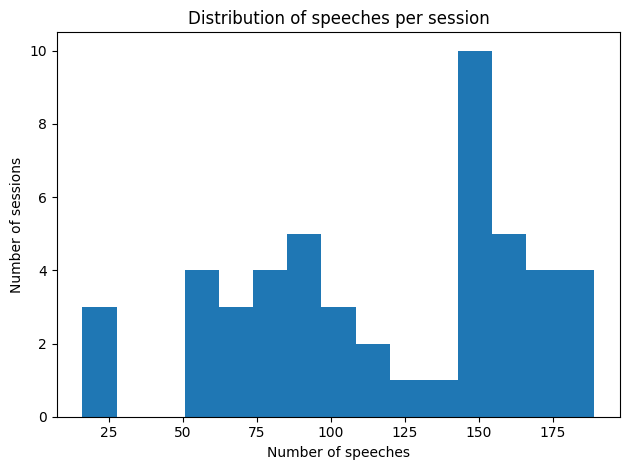

Sessions with most speeches:


,protocol_id,date,n_speeches,n_tops,duration_min
31,5740,2025-10-15,189,8,381
34,5744,2025-11-05,186,7,376
19,5726,2025-09-10,183,8,352
44,5755,2025-12-03,181,7,364
28,5737,2025-10-08,173,7,373
12,5718,2025-06-25,172,7,366
37,5747,2025-11-12,169,7,357
45,5756,2025-12-04,167,17,814
20,5727,2025-09-11,161,21,772
5,5709,2025-05-21,160,7,373


In [ ]:
# Distribution of speeches per session
plt.figure()
plt.hist(sessions_df['n_speeches'], bins=15)
plt.title('Distribution of speeches per session')
plt.xlabel('Number of speeches')
plt.ylabel('Number of sessions')
plt.tight_layout()
plt.show()

print('Sessions with most speeches:')
display(sessions_df.sort_values('n_speeches', ascending=False).head(10)[
    ['protocol_id', 'date', 'n_speeches', 'n_tops', 'duration_min']
])

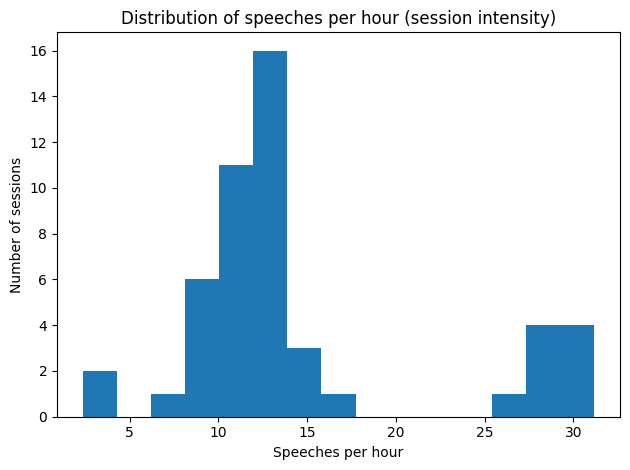

Highest intensity sessions:


,protocol_id,date,speeches_per_hour,n_speeches,duration_min
19,5726,2025-09-10,31.193182,183,352
44,5755,2025-12-03,29.835165,181,364
31,5740,2025-10-15,29.763780,189,381
34,5744,2025-11-05,29.680851,186,376
8,5713,2025-06-04,29.050633,153,316
37,5747,2025-11-12,28.403361,169,357
12,5718,2025-06-25,28.196721,172,366
28,5737,2025-10-08,27.828418,173,373
5,5709,2025-05-21,25.737265,160,373
2,5706,2025-05-14,16.161972,153,568


In [ ]:
# Speeches per hour (controls for session length)
tmp = sessions_df.copy()
tmp['speeches_per_hour'] = tmp['n_speeches'] / (tmp['duration_min'] / 60)

plt.figure()
plt.hist(tmp['speeches_per_hour'], bins=15)
plt.title('Distribution of speeches per hour (session intensity)')
plt.xlabel('Speeches per hour')
plt.ylabel('Number of sessions')
plt.tight_layout()
plt.show()

print('Highest intensity sessions:')
display(tmp.sort_values('speeches_per_hour', ascending=False).head(10)[
    ['protocol_id', 'date', 'speeches_per_hour', 'n_speeches', 'duration_min']
])

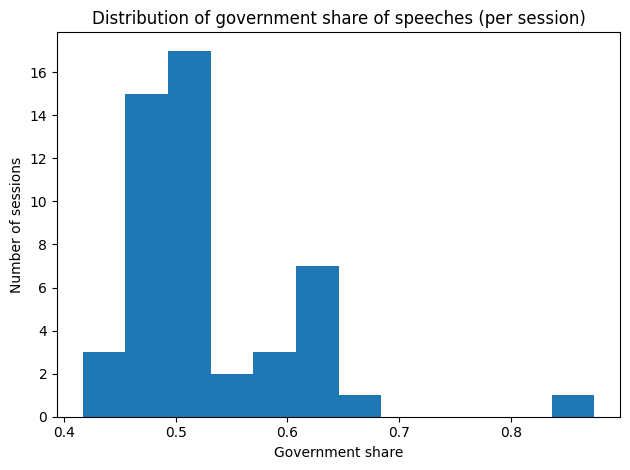

gov_share summary:


,gov_share
count,49.000000
mean,0.524555
std,0.077765
min,0.416667
25%,0.472603
50%,0.506024
75%,0.548387
max,0.875000


In [ ]:
# Government vs Opposition per session
tmp = (
    speeches_df.groupby(['protocol_id', 'bloc']).size()
    .unstack(fill_value=0)
    .reset_index()
    .merge(sessions_df[['protocol_id', 'date']], on='protocol_id', how='left')
)

tmp['gov_share'] = tmp['Government'] / (tmp['Government'] + tmp['Opposition'])

plt.figure()
plt.hist(tmp['gov_share'], bins=12)
plt.title('Distribution of government share of speeches (per session)')
plt.xlabel('Government share')
plt.ylabel('Number of sessions')
plt.tight_layout()
plt.show()

print('gov_share summary:')
display(tmp['gov_share'].describe())

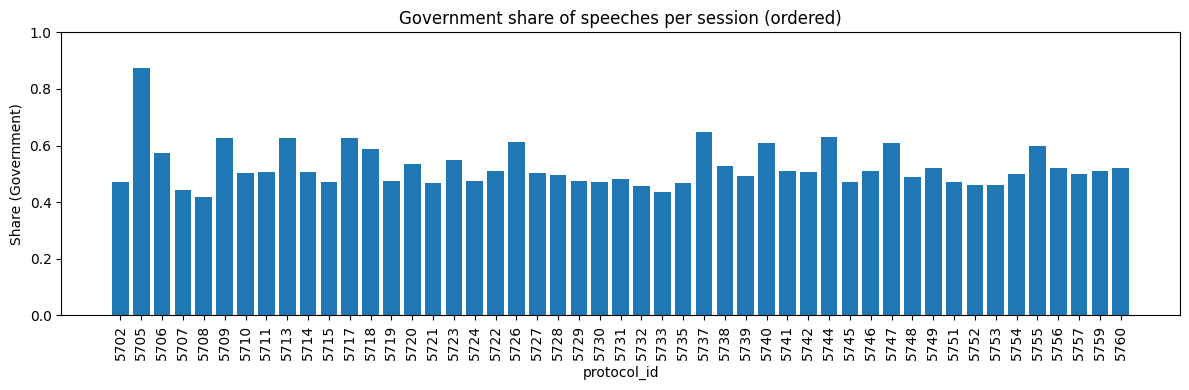

In [ ]:
# Government vs Opposition session-by-session

tmp_sorted = tmp.sort_values('date').reset_index(drop=True)

plt.figure(figsize=(12, 4))
plt.bar(tmp_sorted['protocol_id'], tmp_sorted['gov_share'])
plt.ylim(0, 1)
plt.title('Government share of speeches per session (ordered)')
plt.xlabel('protocol_id')
plt.ylabel('Share (Government)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# -------------------------
# 2) speeches_df descriptives
# -------------------------
print('\n--- Speech-level overview ---')
print('N speeches:', speeches_df.shape[0])
print('\nSpeeches by fraktion:')
display(speeches_df['fraktion'].value_counts())

print('\nSpeeches by bloc:')
display(speeches_df['bloc'].value_counts())

# Speeches per session by bloc
bloc_by_session = (
    speeches_df
    .groupby(['protocol_id', 'bloc'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
print('\nBloc speeches per session (first 5):')
display(bloc_by_session.head())


--- Speech-level overview ---
N speeches: 5763

Speeches by fraktion:


,count
fraktion,
CDU/CSU,1804
SPD,1243
AfD,1225
BÜNDNIS 90/DIE GRÜNEN,837
Die Linke,612
fraktionslos,42



Speeches by bloc:


,count
bloc,
Government,3047
Opposition,2716



Bloc speeches per session (first 5):


bloc,protocol_id,Government,Opposition
0,5702,8,9
1,5705,21,3
2,5706,88,65
3,5707,64,81
4,5708,25,35


In [ ]:
# -------------------------
# 3) speaker descriptives
# -------------------------
print('\n--- Speaker overview ---')
n_speakers = speeches_df['redner_id'].nunique()
print('Unique speakers (redner_id):', n_speakers)

top_speakers = (
    speeches_df
    .groupby(['speaker', 'fraktion', 'role'], as_index=False)
    .size()
    .sort_values('size', ascending=False)
    .head(10)
    .rename(columns={'size': 'n_speeches'})
)
print('\nTop 10 speakers by number of speeches:')
display(top_speakers)


--- Speaker overview ---
Unique speakers (redner_id): 610

Top 10 speakers by number of speeches:


,speaker,fraktion,role,n_speeches
33,Lars Klingbeil,SPD,Bundesminister BMF,82
49,Verena Hubertz,SPD,Bundesministerin BMWSB,64
15,Dr. Johann David Wadephul,CDU/CSU,Bundesminister AA,57
0,Alexander Dobrindt,CDU/CSU,Bundesminister BMI,50
47,Thorsten Frei,CDU/CSU,Bundesminister BK,50
29,Karin Prien,CDU/CSU,Bundesministerin BMBFSFJ,48
3,Boris Pistorius,SPD,Bundesminister BMVg,47
37,Nina Warken,CDU/CSU,Bundeministerin BMG,45
5,Carsten Schneider,SPD,Bundesminister BMUKN,44
38,Patrick Schnieder,CDU/CSU,Bundesminister BMV,44



--- Speech length (words) ---


,n_words
count,5763.000000
mean,483.702412
std,349.041677
min,3.000000
25%,194.000000
50%,476.000000
75%,651.000000
max,5977.000000



Speech length by party:


,fraktion,mean_words,median_words,n
2,CDU/CSU,507.328714,508.0,1804
0,AfD,499.689796,482.0,1225
4,SPD,465.144006,469.0,1243
1,BÜNDNIS 90/DIE GRÜNEN,463.109916,492.0,837
3,Die Linke,457.022876,429.0,612
5,fraktionslos,350.976190,344.0,42


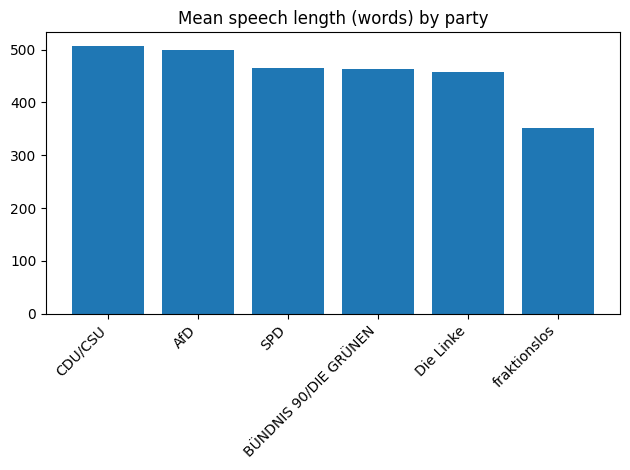

In [ ]:
# -------------------------
# 4) simple speech length descriptives
# -------------------------
if 'n_words' not in speeches_df.columns:
    speeches_df['n_words'] = speeches_df['text'].astype(str).str.split().str.len()

print('\n--- Speech length (words) ---')
display(speeches_df['n_words'].describe())

length_by_party = (
    speeches_df
    .groupby('fraktion', as_index=False)['n_words']
    .agg(mean_words='mean', median_words='median', n='count')
    .sort_values('mean_words', ascending=False)
)
print('\nSpeech length by party:')
display(length_by_party)

# Plot: mean words by party
plt.figure()
plt.bar(length_by_party['fraktion'], length_by_party['mean_words'])
plt.xticks(rotation=45, ha='right')
plt.title('Mean speech length (words) by party')
plt.tight_layout()
plt.show()

# Text Analysis

## spaCy preprocessing → T (tokens per speech)

In [ ]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 49.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# 1) Load spaCy German pipeline (with fallback if model isn't installed)
try:
    nlp = spacy.load('de_core_news_sm', disable=['ner', 'parser'])
    USE_LEMMA = True
    print('Loaded: de_core_news_sm')
except OSError:
    nlp = spacy.blank('de')  # fast fallback: tokenizer + stopwords
    USE_LEMMA = False
    print('Fallback: spacy.blank(\'de\') (no lemma model)')

Loaded: de_core_news_sm


In [ ]:
def normalize_ws(s):
    return re.sub(r'\s+', ' ', str(s).replace('\xa0', ' ')).strip()

def preprocess_doc(doc):
    toks = []
    for token in doc:
        if token.is_space or token.is_stop or token.is_punct or token.like_num or token.like_url:
            continue
        if not token.is_alpha:
            continue

        term = token.lemma_.lower().strip() if USE_LEMMA else token.text.lower().strip()
        if term:
            toks.append(term)
    return toks

# 2) Build T using nlp.pipe
texts = model_df['text'].fillna('').astype(str).tolist()

T = []
for doc in nlp.pipe(texts, batch_size=50):
    T.append(preprocess_doc(doc))

print('Docs in T:', len(T))
print('Example tokens:', T[0][:30])

KeyboardInterrupt: 